<a href="https://colab.research.google.com/github/tlmakinen/imnn/blob/0.2a5/IMNN_shell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
cd ./examples/

/mnt/home/tmakinen/repositories/imnn/examples


In [2]:
import tensorflow as tf 

if tf.test.gpu_device_name(): 

    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:

    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.python.client import device_lib
from IMNN import IMNN
from IMNN.LFI import LFI
#from make_data import GenerateGaussianNoise
#from make_data import AnalyticLikelihood
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

tfd = tfp.distributions



# for autograd functions
#import jax.numpy as jnp
#from jax import grad, jit, vmap
#from jax import random
#import jax.scipy.special as jspecial

#import numpyro
#import numpyro
#import numpyro.distributions as dist

#key = random.PRNGKey(0)


print("IMNN {}\nTensorFlow {}\nTensorFlow Probability {}\nnumpy {}".format(
    IMNN.__version__, tf.__version__, tfp.__version__, np.__version__))

IMNN 0.2a5
TensorFlow 2.3.1
TensorFlow Probability 0.11.1
numpy 1.18.1


In [4]:
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type  == "GPU"]

In [5]:
print(tf.__version__)

2.3.1


# IMNN toy model
Let's try to find a toy problem in which methods like the linear MOPED method fails to recover accurate fiducial parameters, and the IMNN (perhaps) succeeds. We're going to start with generating data on an $N$-dimensional spherical shell. The goal of the exercise will be, given sampled data $\{(x_1, x_2, \dots x_N) \}_i$, with $i = 1, \dots n_d$, we want to recover the fiducial angle in spherical coordinates $\phi$, e.g. $\vec{\theta}_{\rm fid} = (r, \theta, \phi)_{\rm fid}$. Let's get started by coming up with a simulator for the situation.

In [44]:
d = np.zeros((60,3) + (1,))
d[:, 2, :].shape

(60, 1)

In [96]:
# θ_fid ~ {r, θ, \phi, \sigma_θ} = {1., \pi, 2\pi, 0.1}
import argparse
import sys
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IMNN.utils import TFRecords
from IMNN.LFI.LFI import GaussianApproximation

__version__ = "0.2a5"
__author__ = "Lucas Makinen"

class GenerateShellData():
    def __init__(self, input_shape=(20,3), n_params=2, n_summaries=2, n_s=1000, n_d=1000, n_d_small=100,
                 θ_fid=np.array([np.pi / 2, 0.1]), δθ=np.array([0.1, 0.1]), training_seed=0,
                 validation_seed=1):
        self.input_shape = input_shape
        self.coord_input_shape = input_shape #(input_shape[0] // 3,)
        self.n_params = n_params
        self.n_summaries = n_summaries
        self.n_s = n_s
        self.n_d = n_d
        self.n_d_small = n_d_small
        self.θ_fid = θ_fid
        self.δθ = δθ
        self.half_δθ = δθ / 2.
        self.training_seed = training_seed
        self.validation_seed = validation_seed

    def get_fiducial(self, seed, data):
        return data[seed]

    def get_derivative(self, seed, derivative, parameter, data):
        return data[seed, derivative, parameter]

    def check_selection(self, size):
        if size not in ["full", "all", "small"]:
            print("size must be `full`, `all` or `small` describing, respectively "
                  "whether just `n_d=n_s` is returned, or `n_d=n_s` and `n_d_small` "
                  "is returned, or `n_d=n_d_small` is returned.")
            sys.exit()
    
    def check_ftype(self, ftype):
        if ftype not in ["both", "numpy", "tfrecords"]:
            print("size must be `both`, `numpy` or `tfrecords` describing, respectively "
                  "whether both `numpy` and `tfrecords` files are saved, or just either one.")
            sys.exit()

    def angToCart(self, r, theta, phi):
        return np.array([r*np.cos(theta)*np.sin(phi), 
                         r*np.sin(theta)*np.sin(phi), 
                         r*np.cos(phi)])

    def simulator(self, parameters, seed=None, simulator_args=None):
        # if self.input_shape[0] // 3 != 0:
        #     raise AssertionError ("input shape must be divisible by coordinate dimensions !")
        if seed is not None:
            np.random.seed(seed)
        if len(parameters.shape) == 1:
            parameters = parameters[np.newaxis, :]
        if self.n_params == 1:
            parameters = np.repeat(parameters, 2, axis=1)
            parameters[:, 0] = np.zeros_like(parameters[:, 0])
            
        # r coordinate is fixed for this test
        r = np.ones((self.coord_input_shape[0],) + (parameters.shape[0],))*1. #parameters[:, 0]

        # phi coordinate is sampled from U(0,2pi)
        phi = np.random.uniform(low=0., high=2*np.pi, size=(self.coord_input_shape[0],) 
                                + (parameters.shape[0],))
        # theta is the variable we're varying via inputs
        theta = np.random.normal(parameters[:, 0], np.sqrt(parameters[:, 1]), 
                                 size=(self.coord_input_shape[0],) + (parameters.shape[0],))
        
        #d = np.zeros((self.input_shape[0],) + (parameters.shape[0],))
        d = np.zeros(self.input_shape + (parameters.shape[0],))
        #print('param shape: ', parameters.shape)
        x,y,z = self.angToCart(r, theta, phi)
        d[:, 0, :] = x
        d[:, 1, :] = y
        d[:, 2, :] = z
        #d[0::3, :] = x
        #d[1::3, :] = y
        #d[2::3, :] = z

        return np.moveaxis(d,
                  -1, 0)

    def generate_data(self, size="full"):
        self.check_selection(size)
        details = dict(
          input_shape=self.input_shape,
          n_params=self.n_params,
          n_summaries=self.n_summaries,
          n_s=self.n_s,
          n_d=self.n_d,
          θ_fid=self.θ_fid,
          δθ=self.δθ)

        # training base sims
        a_0 = self.simulator(
          parameters=np.repeat(
              self.θ_fid[np.newaxis, :], 
              self.n_s, 
              axis=0),
          seed=self.training_seed,
          simulator_args={"input_shape": self.input_shape})
        # validation base sims
        a_1 = self.simulator(
          parameters=np.repeat(
              self.θ_fid[np.newaxis, :], 
              self.n_s, 
              axis=0),
          seed=self.validation_seed,
          simulator_args={"input_shape": self.input_shape})

        # FOR NOW: TWO parameters: ONLY vary theta and sigma2_theta
        # training -theta
        b_0 = self.simulator(
          parameters=np.repeat(
              np.array([
                  self.θ_fid[0] - self.half_δθ[0],
                  self.θ_fid[1],
                  ])[np.newaxis, :], 
              self.n_d, 
              axis=0),
          seed=self.training_seed,
          simulator_args={"input_shape": self.input_shape})
        # validation -theta
        b_1 = self.simulator(
          parameters=np.repeat(
              np.array([
                  self.θ_fid[0] - self.half_δθ[0],
                  self.θ_fid[1],
                  ])[np.newaxis, :], 
              self.n_d, 
              axis=0),
          seed=self.validation_seed,
          simulator_args={"input_shape": self.input_shape})    
        # training +theta  
        c_0 = self.simulator(
          parameters=np.repeat(
              np.array([
                  self.θ_fid[0] + self.half_δθ[0],
                  self.θ_fid[1],
                  ])[np.newaxis, :], 
              self.n_d, 
              axis=0),
          seed=self.training_seed,
          simulator_args={"input_shape": self.input_shape})
        # validation +theta
        c_1 = self.simulator(
          parameters=np.repeat(
              np.array([
                  self.θ_fid[0] + self.half_δθ[0],
                  self.θ_fid[1],
                  ])[np.newaxis, :], 
              self.n_d, 
              axis=0),
          seed=self.validation_seed,
          simulator_args={"input_shape": self.input_shape})
        # training -sigma2theta
        d_0 = self.simulator(
          parameters=np.repeat(
              np.array([
                  self.θ_fid[0], 
                  self.θ_fid[1] - self.half_δθ[1],
                  ])[np.newaxis, :], 
              self.n_d, 
              axis=0),
          seed=self.training_seed,
          simulator_args={"input_shape": self.input_shape})
        # validation -sigma2theta
        d_1 = self.simulator(
          parameters=np.repeat(
              np.array([
                  self.θ_fid[0], 
                  self.θ_fid[1] - self.half_δθ[1],
                  ])[np.newaxis, :], 
              self.n_d, 
              axis=0),
          seed=self.validation_seed,
          simulator_args={"input_shape": self.input_shape})  
        # training +sigma2theta     
        e_0 = self.simulator(
          parameters=np.repeat(
              np.array([
                  self.θ_fid[0], 
                  self.θ_fid[1] + self.half_δθ[1],
                  ])[np.newaxis, :], 
              self.n_d, 
              axis=0),
          seed=self.training_seed,
          simulator_args={"input_shape": self.input_shape})
        # validation +sigma2theta
        e_1 = self.simulator(
          parameters=np.repeat(
              np.array([
                  self.θ_fid[0], 
                  self.θ_fid[1] + self.half_δθ[1],
                  ])[np.newaxis, :], 
              self.n_d, 
              axis=0),
          seed=self.validation_seed,
          simulator_args={"input_shape": self.input_shape}) 

        print('b0 shape : ', b_0.shape)
            
        f_0 = np.stack((np.stack((b_0, c_0)), 
                          np.stack((d_0, e_0)))
                        ).transpose(2, 1, 0, 3, 4)
        f_1 = np.stack((np.stack((b_1, c_1)), 
                          np.stack((d_1, e_1)))
                        ).transpose(2, 1, 0, 3, 4)

        result = (details, a_0, a_1, f_0, f_1)
          
        if size == "all":
            details["n_d_small"] = self.n_d_small
            result += (f_0[:self.n_d_small],
                    f_1[:self.n_d_small])
        elif size == "small":
            details["n_d"] = self.n_d_small
            result[-2] = f_0[:self.n_d_small]
            result[-1] = f_1[:self.n_d_small]

        return result
    
    def save(self, ftype="both", size="full", directory="data", record_size=0.01):
        self.check_ftype(ftype)
        result = self.generate_data(size=size)
        
        if (ftype=="both") or (ftype=="numpy"):
            np.savez("{}/details.npz".format(directory), result[0])
            np.save("{}/fiducial.npy".format(directory), result[1])
            np.save("{}/validation_fiducial.npy".format(directory), result[2])    
            np.save("{}/derivative.npy".format(directory), result[3])
            np.save("{}/validation_derivative.npy".format(directory), result[4])
            if size == "all":
                np.save("{}/derivative_small.npy".format(directory), result[5])
                np.save("{}/validation_derivative_small.npy".format(directory), result[6])

        if (ftype=="both") or (ftype=="tfrecords"):
            writer = TFRecords.TFRecords(record_size=record_size)
            
            writer.write_record(
                n_sims=result[0]["n_s"], 
                get_simulation=lambda x : self.get_fiducial(x, result[1]),
                fiducial=True, 
                directory="{}/tfrecords".format(directory))
            writer.write_record(
                n_sims=result[0]["n_s"], 
                get_simulation=lambda x : self.get_fiducial(x, result[2]),
                fiducial=True, 
                validation=True,
                directory="{}/tfrecords".format(directory))
            writer.write_record(
                n_sims=result[0]["n_d"], 
                get_simulation=lambda x, y, z : self.get_derivative(x, y, z, result[3]),
                fiducial=False,
                n_params=result[0]["n_params"],
                directory="{}/tfrecords".format(directory))
            writer.write_record(
                n_sims=result[0]["n_d"], 
                get_simulation=lambda x, y, z : self.get_derivative(x, y, z, result[4]),
                fiducial=False,
                n_params=result[0]["n_params"],
                validation=True,
                directory="{}/tfrecords".format(directory))
            if size == "all":
                writer.write_record(
                    n_sims=result[0]["n_d_small"], 
                    get_simulation=lambda x, y, z : self.get_derivative(x, y, z, result[5]),
                    fiducial=False,
                    n_params=result[0]["n_params"],
                    directory="{}/tfrecords".format(directory),
                    filename="derivative_small")
                writer.write_record(
                    n_sims=result[0]["n_d_small"], 
                    get_simulation=lambda x, y, z : self.get_derivative(x, y, z, result[6]),
                    fiducial=False,
                    n_params=result[0]["n_params"],
                    directory="{}/tfrecords".format(directory),
                    filename="derivative_small")
                
    def plot_data(self, data, ax=None, label=None, 
                  viewang1=20, viewang2=40):

        fig = plt.figure(figsize = (5, 4))
        ax = fig.add_subplot(111, projection='3d')
        print(data.T.shape)
        #xs,ys,zs = data.T[::3], data.T[1::3], data.T[2::3]
        xs,ys,zs = data.T[0], data.T[1], data.T[2]
        ax.scatter(xs, ys, zs, zdir='z', s=20, c=None, depthshade=True)
        
        ax.legend(frameon=False)
        # ax.set_xticks([])
        # ax.set_zticks([])
        ax.set_xlabel("x");
        ax.set_ylabel("y");
        ax.set_zlabel("z");


        # rotate the axes
        ax.view_init(viewang1, viewang2)
        ax.set_zlim(-1, 1)
        ax.set_ylim(-1, 1)
        ax.set_xlim(-1, 1)

        return fig,ax # for further modification


Let's take a look at a single simulation of our data:

No handles with labels found to put in legend.


(3, 20, 1)


(<Figure size 360x288 with 1 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x1554647f6b90>)

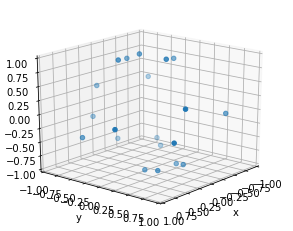

In [97]:
generator = GenerateShellData(input_shape=(20,3))

θ_target = np.array([np.pi/2., 2.0])[np.newaxis, :]
target_data = generator.simulator(
    parameters=θ_target,
    seed=37,
    simulator_args={"input_shape": generator.input_shape})

generator.plot_data(target_data, label="Observed data")

Now that we've constructed our simulator, let's generate a set of data with noisy $\varphi$ parameter, draw $\phi$ uniformly at random, and fix $r$. This dataset will correspond to a ring of fixed radius on a 3D sphere. We'll visualize it below.

In [98]:
# define fiducial parameters and create data vector, d
θ_fid = np.array([np.pi / 2, 2.0]) # theta, sigma^2_theta

In [99]:
SN = GenerateShellData(n_s=10000, n_d=10000, input_shape=(30,3))
details, fiducial, validation_fiducial, derivative, validation_derivative = SN.generate_data()

b0 shape :  (10000, 30, 3)


In [100]:
print("fiducial = {}\nvalidation_fiducial = {}\nderivative = {}\nvalidation_derivative = {}".format(
    fiducial.shape, validation_fiducial.shape, derivative.shape, validation_derivative.shape))

fiducial = (10000, 30, 3)
validation_fiducial = (10000, 30, 3)
derivative = (10000, 2, 2, 30, 3)
validation_derivative = (10000, 2, 2, 30, 3)


Now le but: We want to know firstly how well IMNN can tackle this problem, given a fiducial model to train on. Goals for right now:


1.   Train IMNN on fiducial parameters (set $\varphi_{\rm fid} = \frac{\pi}{2}$ for now)
2.   Compare to MOPED algorithm



In [101]:
def fiducial_loader(seed, data):
    yield data[seed], seed

def derivative_loader(seed, derivative, parameter, data):
    yield data[seed, derivative, parameter], (seed, derivative, parameter)

In [112]:
SN.input_shape

(30, 3)

In [139]:
model = tf.keras.Sequential(
    [tf.keras.Input(shape=SN.input_shape),
     #tf.keras.layers.Conv1D(30,1),
     tf.keras.layers.Dense(128),
     tf.keras.layers.LeakyReLU(0.01),
     tf.keras.layers.Reshape((128*SN.input_shape[0],)),
     tf.keras.layers.Dense(128),
     tf.keras.layers.LeakyReLU(0.01),
     tf.keras.layers.Dense(SN.n_summaries),
     #tf.keras.layers.Reshape((2,))
    ])
opt = tf.keras.optimizers.Adam()

In [140]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_58 (Dense)             (None, 30, 128)           512       
_________________________________________________________________
leaky_re_lu_39 (LeakyReLU)   (None, 30, 128)           0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 3840)              0         
_________________________________________________________________
dense_59 (Dense)             (None, 128)               491648    
_________________________________________________________________
leaky_re_lu_40 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dense_60 (Dense)             (None, 2)                 258       
Total params: 492,418
Trainable params: 492,418
Non-trainable params: 0
_______________________________________________

In [144]:
imnn = IMNN.IMNN(n_s=SN.n_s, n_d=SN.n_d, n_params=SN.n_params, n_summaries=SN.n_summaries,
                 model=model, optimiser=opt, θ_fid=θ_fid, δθ=np.array([0.1,0.1]), input_shape=SN.input_shape,
                 fiducial=lambda x : fiducial_loader(x, fiducial), 
                 derivative=lambda x, y, z : derivative_loader(x, y, z, derivative), 
                 validation_fiducial=lambda x : fiducial_loader(x, validation_fiducial),
                 validation_derivative=lambda x, y, z : derivative_loader(x, y, z, validation_derivative), 
                 at_once=SN.n_s, check_shape=True, verbose=True,
                 directory="model", filename="structured_ring", save=True)

input shape will be (30, 3)
saving model to model/structured_ring
INFO:tensorflow:Assets written to: model/structured_ring/assets


In [145]:
#imnn.load_model(opt, weights='weights')

In [146]:
imnn.fit(patience=10, min_iterations=1000, tqdm_notebook=False, checkpoint=100)

Iterations: 0it [00:00, ?it/s]

Using patience length of 10. Maximum number of training iterations is 10000000000.
Saving current model in model/structured_ring


Iterations: 9097it [1:14:14,  2.06it/s, det_F=1.93e+5, det_C=0.92, det_Cinv=1.09, r=0.0969, val_det_F=1.69e+5, val_det_C=1.05, val_det_Cinv=0.952, patience=0]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Iterations: 14065it [1:54:26,  1.97it/s, det_F=7.34e+5, det_C=0.988, det_Cinv=1.01, r=0.000816, val_det_F=4.12e+5, val_det_C=1.49, val_det_Cinv=0.67, patience=11]

Reached 10 steps without increasing val_det_F. Resetting weights to iteration 14053.


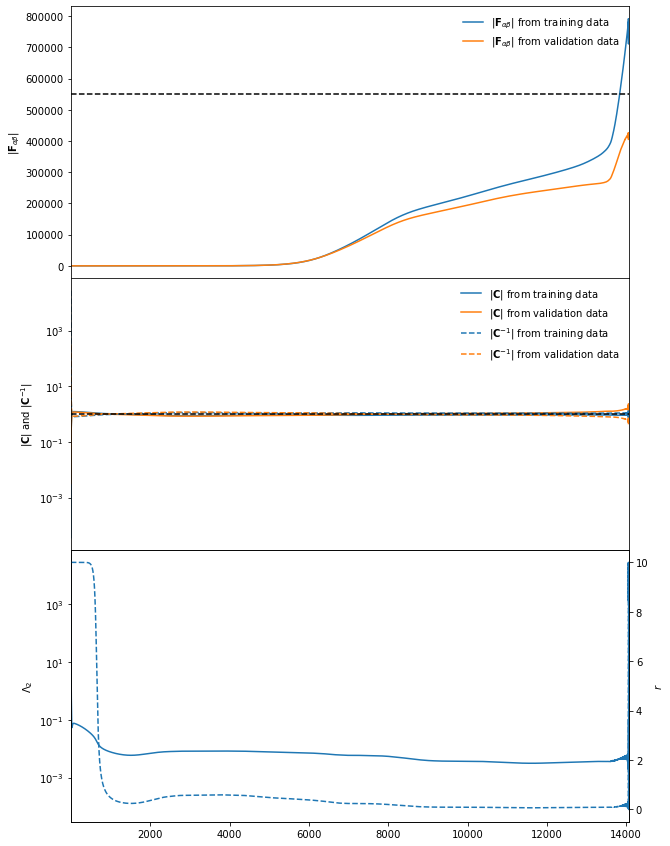

In [148]:
imnn.plot(known_det_fisher=5.5e5)

No handles with labels found to put in legend.


(3, 30, 1)


(<Figure size 360x288 with 1 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x1553dff402d0>)

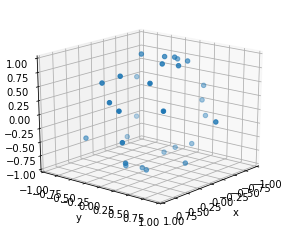

In [196]:
generator = GenerateShellData(input_shape=(30,3))

θ_target = np.array([0.01, 0.5])[np.newaxis, :]
target_data = generator.simulator(
    parameters=θ_target,
    seed=37,
    simulator_args={"input_shape": generator.input_shape})

generator.plot_data(target_data, label="Observed data")

In [197]:
prior = tfd.Blockwise([tfd.Uniform(-np.pi/2, np.pi/2),
                       tfd.Uniform(0.01, 5.)])

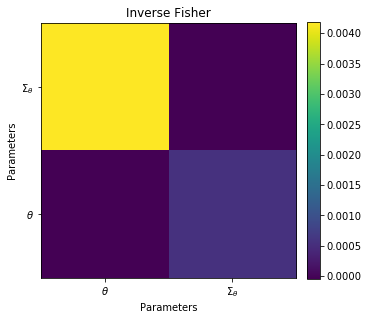

In [198]:
GA = LFI.GaussianApproximation(
    target_data=target_data.astype(np.float32), 
    prior=prior, 
    Fisher=imnn.F,
    get_estimate=imnn.get_estimate,
    labels=[r"$\theta$", r"$\Sigma_\theta$"])

GA.plot_Fisher(figsize=(5, 5));


In [199]:
θ_target[0][1]

0.5

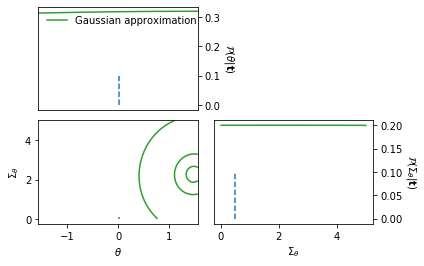

In [200]:
ax = GA.plot(
    gridsize=(1000, 1000),
    color="C2",
    label="Gaussian approximation");

ax[0][0].plot(np.ones(10)*θ_target[0][0], np.linspace(-0.001,0.1, 10), linestyle='--')
ax[1][0].plot(np.ones(10)*θ_target[0][0], np.linspace(-0.001,0.1, 10), linestyle='--')

#ax[0][1].plot(np.ones(10)*np.pi/2, np.linspace(-0.001,0.05, 10))
ax[1][1].plot(np.ones(10)*θ_target[0][1], np.linspace(-0.001,0.1, 10), linestyle='--')

In [201]:
# run ABC computation
ABC = LFI.ApproximateBayesianComputation(
    target_data=target_data.astype(np.float32), 
    prior=prior, 
    Fisher=imnn.F,
    get_estimate=imnn.get_estimate,
    simulator=lambda x : SN.simulator(
        x, None, {"input_shape": SN.input_shape}),
    labels=[r"$\theta$", r"$\Sigma_\theta$"])

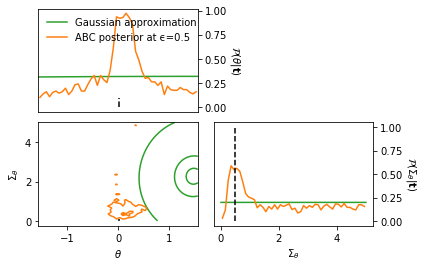

In [202]:
ax = GA.plot(
    gridsize=(1000, 1000),
    color="C2",
    label="Gaussian approximation");
ABC.plot(
    ϵ=0.5,
    accepted=2000,
    draws=100000,
    ax=ax,
    color="C1",
    label="ABC posterior at ϵ={}".format(0.5),
    smoothing=0,
    bins=50);


ax[0][0].plot(np.ones(10)*θ_target[0][0], np.linspace(-0.001,0.1, 10), linestyle='--', color='k')
ax[1][0].plot(np.ones(10)*θ_target[0][0], np.linspace(-0.001,0.1, 10), linestyle='--', color='k')

ax[1][1].plot(np.ones(10)*θ_target[0][1], np.linspace(-0.001,1., 10), linestyle='--', color='k')

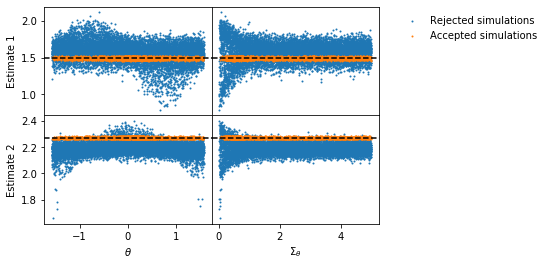

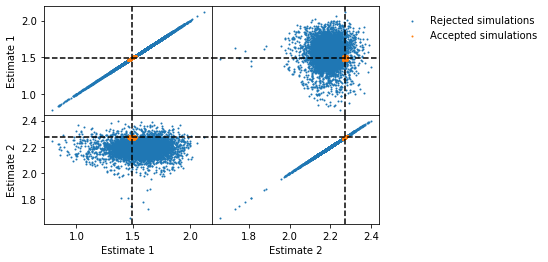

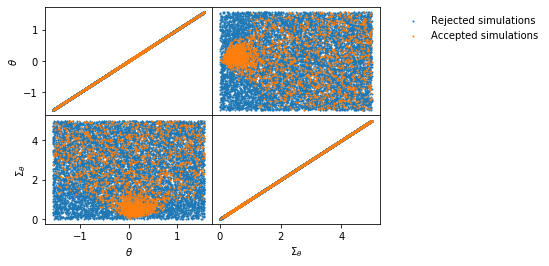

In [203]:
ABC.scatter_plot(axes="parameter_estimate", rejected=0.01);
ABC.scatter_plot(axes="estimate_estimate", rejected=0.01);
ABC.scatter_plot(axes="parameter_parameter", rejected=0.01);

In [204]:
PMC = LFI.PopulationMonteCarlo(
    target_data=target_data.astype(np.float32), 
    prior=prior, 
    Fisher=imnn.F,
    get_estimate=imnn.get_estimate,
    simulator=lambda x : SN.simulator(
        x, None, {"input_shape": SN.input_shape}),
    labels=[r"$\theta$", r"$\Sigma_\theta$"])

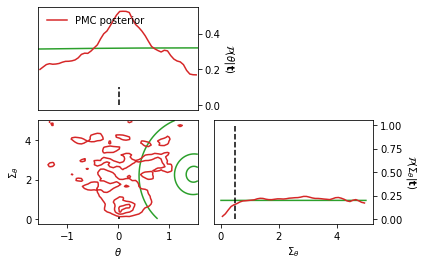

In [205]:
ax = GA.plot(
    gridsize=(1000, 1000),
    color="C2",
    label=None);

# ax = ABC.plot(
#     gridsize=(1000, 1000),
#     ϵ=0.5,
#     accepted=2000,
#     draws=100000,
#     ax=ax,
#     color="C1",
#     label="ABC posterior at ϵ={}".format(0.5),
#     smoothing=0,
#     bins=50);

PMC.plot(
    draws=5000,
    initial_draws=8000,
    criterion=1,
    percentile=75,
    ax=ax,
    color="C3",
    label="PMC posterior",
    smoothing=1,
    bins=50);

ax[0][0].plot(np.ones(10)*θ_target[0][0], np.linspace(-0.001,0.1, 10), linestyle='--', color='k')
ax[1][0].plot(np.ones(10)*θ_target[0][0], np.linspace(-0.001,0.1, 10), linestyle='--', color='k')

ax[1][1].plot(np.ones(10)*θ_target[0][1], np.linspace(-0.001,1., 10), linestyle='--', color='k')


In [112]:
%tb

SystemExit: 

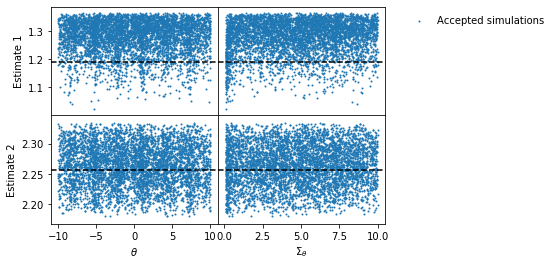

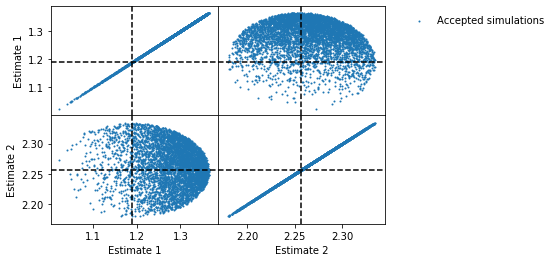

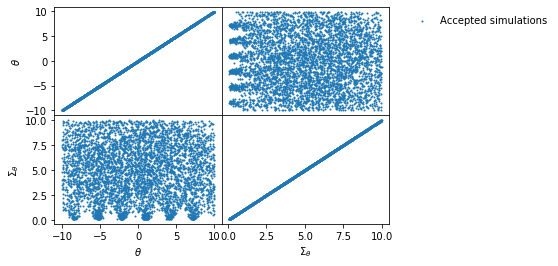

In [100]:
PMC.scatter_plot(axes="parameter_estimate")
PMC.scatter_plot(axes="estimate_estimate")
PMC.scatter_plot(axes="parameter_parameter")

In [430]:
def curve(t, rate, dims=5, sig=0.5, active_dims=1):
    nd = len(t)
    d = np.zeros((dims, nd))
    for i,dim in enumerate(d[:-active_dims]):
        if i%2 == 0:
            d[i, :] = np.ones(nd)*np.sin(t) + np.random.normal(scale=sig, size=t.shape)
        else:
            d[i, :] = np.ones(nd)*np.cos(t) + np.random.normal(scale=sig, size=t.shape)
    for i in range(active_dims):
        d[-(i+1), :] = t*rate + np.random.normal(scale=sig, size=t.shape) #np.exp(-t/rate)
    return d

In [431]:
np.zeros((5, 20))[:-1].shape

(4, 20)

In [445]:
t = np.linspace(0, 30, 100)
rate = 0.5
c = curve(t, rate, dims=20, active_dims=4)

In [446]:
np.cov(c).shape

(20, 20)

No handles with labels found to put in legend.


(100, 20)


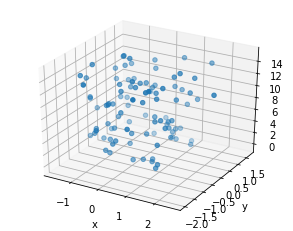

In [447]:
fig = plt.figure(figsize = (5, 4))
ax = fig.add_subplot(111, projection='3d')
print(c.T.shape)
#xs,ys,zs = data.T[::3], data.T[1::3], data.T[2::3]
xs,ys = c[2:4]
zs = c[-3]
ax.scatter(xs, ys, zs, zdir='z', s=20, c=None, depthshade=True)

ax.legend(frameon=False)
# ax.set_xticks([])
# ax.set_zticks([])
ax.set_xlabel("x");
ax.set_ylabel("y");
ax.set_zlabel("z");